In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import zscore

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import chi2, SelectKBest, SelectFromModel
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

plt.rcParams.update({'figure.figsize': (16, 6)})

Читаем данные из файла.
Удаляем строки с отсутствующими данными.
Для количественных признаков считаем выбросом отклонение от выборочного среднего больше чем на три сигмы. 

In [2]:
df = pd.read_csv('./data/raw/flights.csv')

df = df.drop(columns=['Unnamed: 9'])
df = df.dropna()

for column in ['DEP_DELAY', 'DISTANCE']:
    df = df[np.abs(zscore(df[column], axis=0)) < 3]
    
df = df.sample(n=10_000)

In [3]:
df.describe()

,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,DEP_DELAY,CANCELLED,DIVERTED,DISTANCE
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,15.28450,3.872100,1326.577300,2.056600,0.000400,0.001300,719.268600
std,8.69282,1.993775,472.470339,14.263932,0.019997,0.036034,493.975494
min,1.00000,1.000000,9.000000,-25.000000,0.000000,0.000000,56.000000
25%,8.00000,2.000000,927.750000,-5.000000,0.000000,0.000000,343.000000
50%,15.00000,4.000000,1323.000000,-2.000000,0.000000,0.000000,594.000000
75%,23.00000,6.000000,1724.000000,2.000000,0.000000,0.000000,967.000000
max,30.00000,7.000000,2355.000000,87.000000,1.000000,1.000000,2466.000000


День недели и время суток признаки не порядковые, преобразуем их с ohe-hot.
Пока не исключаем первый бинарный признак, он понадобится для группировки в дальнейшем.

In [4]:
for i, day in enumerate(['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THIRSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY']):
    df[day] = (df['DAY_OF_WEEK'] == i + 1).astype('int32')

df['MORNING'] = (df['DEP_TIME'].between(500, 1200)).astype('int32')
df['DAY'] = (df['DEP_TIME'].between(1200, 1600)).astype('int32')
df['EVENING'] = (df['DEP_TIME'].between(1600, 2200)).astype('int32')
df['NIGHT'] = (df['DEP_TIME'].between(2200, 2400) | df['DEP_TIME'].between(0, 500)).astype('int32')

df = df.drop(columns=['DAY_OF_WEEK', 'DEP_TIME'])

Проверим значимость признаков.
Для начала строим корреляционную матрицу.
Можно заметить, что дни недели, отмена полета и смена курса почти не коррелируют с задержкой вылета.

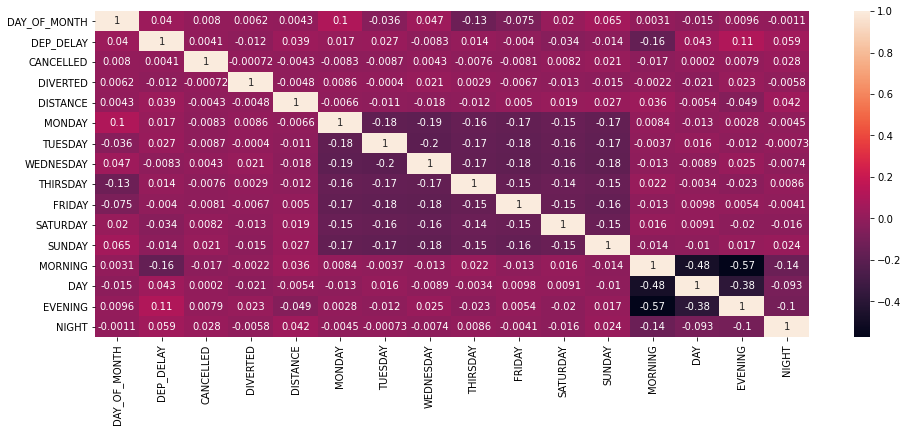

In [5]:
sns.heatmap(df.corr(), annot=True)

Далее вычисляем feature importance для признаков, используя random forest.
Используем 50 решающих деревьев.

In [6]:
# Should not exceed ~50k
df_reduced = df.sample(n=10_000)

y = df_reduced[['DEP_DELAY']]
X = df_reduced.drop(columns=['DEP_DELAY', 'OP_UNIQUE_CARRIER', 'ORIGIN'])

estimator = ExtraTreesClassifier(n_estimators=50)
estimator = estimator.fit(X, y.values.ravel())

Наибольшая значимость наблюдается у признака расстояния, следом у дня месяца.

In [7]:
importances = pd.DataFrame({
    'feature': [f for f in df_reduced.columns if f not in ['DEP_DELAY', 'OP_UNIQUE_CARRIER', 'ORIGIN']],
    'importance': estimator.feature_importances_
})

importances.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
feature,DAY_OF_MONTH,CANCELLED,DIVERTED,DISTANCE,MONDAY,TUESDAY,WEDNESDAY,THIRSDAY,FRIDAY,SATURDAY,SUNDAY,MORNING,DAY,EVENING,NIGHT
importance,0.046236,0.000404,0.000802,0.937603,0.001413,0.00144,0.001548,0.001281,0.001302,0.001247,0.001349,0.001312,0.001597,0.00144,0.001026


Опять замечаем, что по отдельности дни недели не влияют на target.
Заменим эти признаки на выходные/не выходные.
Также удалим cancelled и diverted, так как они снова не продемонстрировали своей значимости при предсказании.

In [8]:
df = df.drop(columns=['CANCELLED', 'DIVERTED'])

df['WEEKDAY'] = df[['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THIRSDAY', 'FRIDAY']].any(axis='columns').astype('int32')
df['WEEKEND'] = df[['SATURDAY', 'SUNDAY']].any(axis='columns').astype('int32')

df = df.drop(columns=['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THIRSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY'])

Избавимся от линейной зависимости, удалим критерии weekend и morning.

In [9]:
df = df.drop(columns=['WEEKEND', 'MORNING'])

Оценим признаки.
Снова строим корреляционную матрицу.

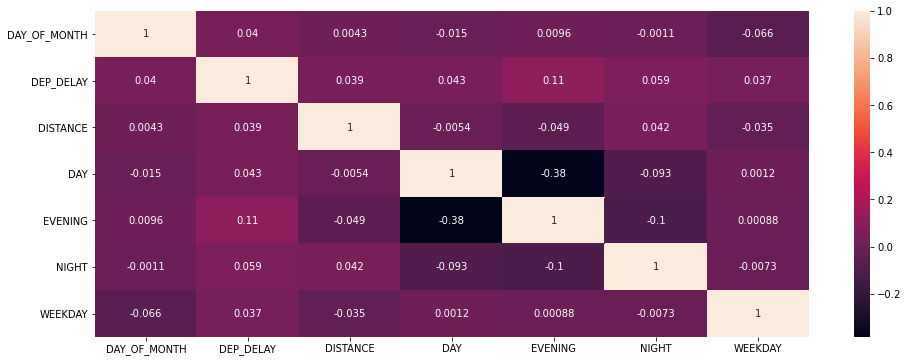

In [10]:
sns.heatmap(df.corr(), annot=True)

Тесты показывают, что квадрат детерминации в среднем в 1.8 раз выше при включении аэропортов и авиаперевозчиков.
Добавим признаки origin и carrier соответственно.
Используем one-hot encoding для преобразования категориальных признаков.

In [11]:
df = pd.get_dummies(df, prefix=['CARRIER'], columns=['OP_UNIQUE_CARRIER'], drop_first=True)
df = pd.get_dummies(df, prefix=['ORIGIN'], columns=['ORIGIN'], drop_first=True)

Для построения уравнения регрессии масштабируем данные.

In [12]:
scaler = MinMaxScaler()
features = [c for c in df.columns if c != 'DEP_DELAY']
df[features] = scaler.fit_transform(df[features]) 

Делим данные на тренировочные и тестовые в отношении 4 к 1.

In [13]:
y = df[['DEP_DELAY']]
X = df.drop(columns=['DEP_DELAY'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

Программма с SGD изначально читала матрицы из файла, не будем её переписывать.
Раскидаем финальные матрицы по соответствующим файлам.

In [14]:
np.savetxt('./data/train/X.csv', X=X_train, fmt='%.18f', delimiter=',')
np.savetxt('./data/train/y.csv', X=y_train, fmt='%.18f', delimiter=',')

np.savetxt('./data/test/X.csv', X=X_test, fmt='%.18f', delimiter=',')
np.savetxt('./data/test/y.csv', X=y_test, fmt='%.18f', delimiter=',')

Будем сравнивать работу нашей программы с работой SGD в scikit-learn.
Оттуда копировали интерфейс.

In [15]:
regression = SGDRegressor(early_stopping=True, verbose=1).fit(X_train, y_train)

-- Epoch 1
Norm: 6.16, NNZs: 263, Bias: -1.003229, T: 7200, Avg. loss: 88.829035
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 7.95, NNZs: 263, Bias: -1.990993, T: 14400, Avg. loss: 87.322149
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 9.57, NNZs: 263, Bias: -1.968531, T: 21600, Avg. loss: 86.758690
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 10.40, NNZs: 263, Bias: -2.734828, T: 28800, Avg. loss: 86.466191
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 11.40, NNZs: 263, Bias: -2.695381, T: 36000, Avg. loss: 86.189107
Total training time: 0.05 seconds.
-- Epoch 6
Norm: 11.99, NNZs: 263, Bias: -3.171974, T: 43200, Avg. loss: 86.014115
Total training time: 0.06 seconds.
-- Epoch 7
Norm: 12.55, NNZs: 263, Bias: -3.392672, T: 50400, Avg. loss: 85.884977
Total training time: 0.07 seconds.
-- Epoch 8
Norm: 13.17, NNZs: 263, Bias: -3.420126, T: 57600, Avg. loss: 85.844961
Total training time: 0.08 seconds.
-- Epoch 9
Norm: 13.71, NNZs: 263, Bias: -3.397649, T: 64800

/home/dikuchan/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [16]:
print(f'R2 Score: {regression.score(X_train, y_train)}')

R2 Score: 0.06397171900985343


In [17]:
print(f'Weights with Scikit SGD: {regression.intercept_}, {regression.coef_[:15]}')

Weights with Scikit SGD: [-3.6341623], [ 1.63478591  2.96726433  3.28123971  5.0015519   6.2014438   1.42939668
 -1.42837479  0.99770811  1.50815163 -0.08011475 -0.07272728 -0.48168283
 -3.11087534 -0.84050729 -0.69903855]


К сожалению, вывод при verbose=1 не отображается непосредственно в ноутбуке.

In [18]:
from regression import Regressor, assess_alpha

alpha = assess_alpha(k=5, left=0.0001, right=0.0005, size=20, penalty='l2')

print(f'Optimal alpha: {alpha}')

Optimal alpha: 0.000428


In [19]:
regression = Regressor(method='sgd', alpha=alpha, tolerance=0.001, eta=0.01, stumble=2)
n = len(df.columns)
weights = regression.fit(n=n)

print(f'Weights with bare SGD: {np.array(weights)[:15]}')

Weights with bare SGD: [-3.6220945   1.57697118  3.02074948  3.57824053  4.86949228  7.14471723
  1.50945877 -1.60714418  0.65073219  1.42427918 -0.29649524 -0.02327621
 -0.58483367 -3.07881148 -1.31241655]


Рассмотрим коэффициенты при выделенных выше признаках.

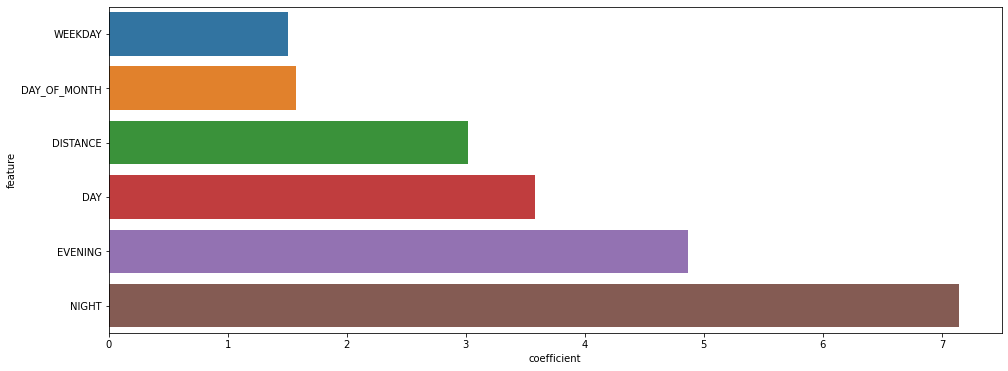

In [20]:
coefficients = pd.DataFrame({
    'feature': [''] + [f for f in df.columns if f != 'DEP_DELAY'][:6],
    'coefficient': weights[:7]
})

sns.barplot(x='coefficient', y='feature', data=coefficients[1:].sort_values(by=['coefficient']))

Отдельно выделим коэффициенты при признаках origin и carrier.
Рассмотрим, какие аэропорты и авиаперевозчики отличились.

In [21]:
residual_coefficients = pd.DataFrame({
    'feature': [f for f in df.columns if f != 'DEP_DELAY'][6:],
    'coefficient': weights[7:]
}).sort_values(by=['coefficient'])

origin_coefficients = residual_coefficients[residual_coefficients['feature'].str.startswith('ORIGIN')]
carrier_coefficients = residual_coefficients[residual_coefficients['feature'].str.startswith('CARRIER')]

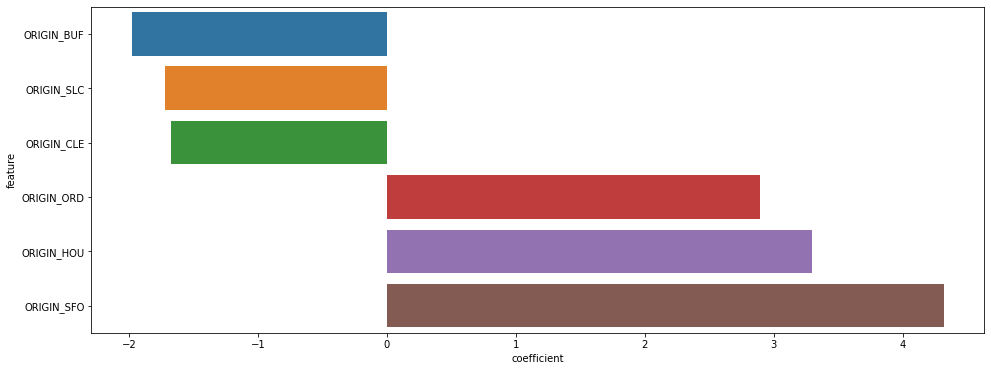

In [22]:
o = origin_coefficients.sort_values(by=['coefficient'])
data = pd.concat([o.head(3), o.tail(3)])

sns.barplot(x='coefficient', y='feature', data=data)

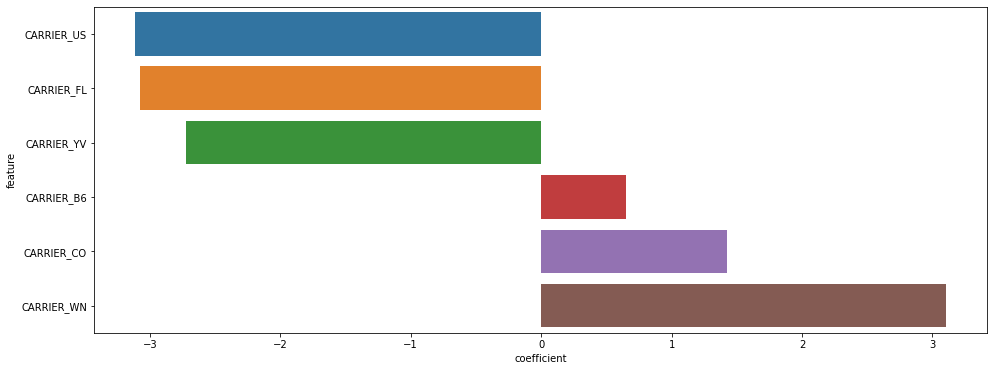

In [23]:
c = carrier_coefficients.sort_values(by=['coefficient'])
data = pd.concat([c.head(3), c.tail(3)])

sns.barplot(x='coefficient', y='feature', data=data)